# Import and Initialize

In [1]:
# Plotting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Reshape, Lambda, MultiHeadAttention, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.model_selection import KFold

# Preprocessing
import numpy as np
import cv2
from PIL import Image
from skimage.color import rgb2gray, rgb2hsv

In [2]:
###############################################################
#             SET FIRST IF USING LOCAL OR COLAB               #
###############################################################


##############################

USING_LOCAL = True

##############################


if (USING_LOCAL):
    # set gpu to be the one doing the computation
    phy_devices = tf.config.experimental.list_physical_devices('GPU')
    print(phy_devices)
    if phy_devices:
        tf.config.experimental.set_memory_growth(phy_devices[0], True)
        
    # this folder must exist in your local where this ntbk is located
    # the folder 'data' must contain the dir of your dataset
#     root = '../cnn/my-first-cnn/data'
    root = 'data'
    
    #Drei's root path to datasets
    #root = 'D:/Andrei/Andrei/Prog Applications/datasets'
else:
    # mount google drive to get the dataset
    from google.colab import drive
    drive.mount('/content/drive')
    
    # set root path of the dataset
    # create shortcut of the dataset to your own drive
    # 'Shared with me' dir wont work
    root = '/content/drive/skewl/Dataset'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Define Functions

### Get datasets

In [3]:
def get_train_X_and_Y(train_path, size=(224,224), batch_size=1):
    train_batch = tf.keras.utils.image_dataset_from_directory(
        directory=train_path, 
        image_size=size,
        labels='inferred',
        label_mode='int',
        shuffle=True,
        batch_size=batch_size,
        seed = 9
    )
    
    X = []
    Y = []
    for images, labels in train_batch.take(-1):
        X.append(images.numpy()[0,:,:,:])
        Y.append(labels.numpy()[0])
    return np.array(X), np.array(Y)

def get_train_XY_and_valid(train_path, size=(224,224), batch_size=1, split=.15):
    train_batch = tf.keras.utils.image_dataset_from_directory(
        directory=train_path, 
        image_size=size,
        labels='inferred',
        label_mode='int',
        shuffle=True,
        validation_split=split,
        batch_size=batch_size,
        subset="training",
        seed = 9
    )
    
    valid_batch = tf.keras.utils.image_dataset_from_directory(
        directory=train_path, 
        image_size=size, 
        labels='inferred',
        label_mode='int',
        validation_split=split,
        batch_size=batch_size,
        shuffle=True,
        subset='validation',
        seed = 9
    )
    
    X = []
    Y = []
    for images, labels in train_batch.take(-1):
        X.append(images.numpy()[0,:,:,:])
        Y.append(labels.numpy()[0])
        
    return np.array(X), np.array(Y), valid_batch


def get_test(test_path, size=(224,224), batch_size=1):
    test_batch = tf.keras.utils.image_dataset_from_directory(
        directory=test_path, 
        image_size=size, 
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
    )

    X = []
    Y = []
    for images, labels in test_batch.take(-1):
        X.append(images.numpy()[0,:,:,:])
        Y.append(labels.numpy()[0])
    return np.array(X), np.array(Y), test_batch

In [4]:
# X, Y = get_train_X_and_Y(train_path)

In [5]:
# print(Y)

### Plotting batch images

In [6]:
def plotImagesWithBatch(batch):
    imgs, labels = next(batch)
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(imgs, axes):
        ax.imshow(img/255)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
# plt.figure(figsize=(10, 10))
# for i in range(12):
#     ax = plt.subplot(4, 4, i + 1)
#     image = X[i][0,:,:,:]
#     plt.imshow(image.astype("uint8"))
#     plt.title(class_names[Y[i][0]])
#     plt.axis("off")

### Model function

In [8]:
def ReshapeLayer(x):
    shape = x.shape
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    return reshape

# Training the Model

### Set Training Variables

In [9]:

# dataset_path = f'{root}/CompletePreprocess_RiceDiseaseDataset'
#dataset_path = f'{root}/PreprocessedRiceDiseaseDataset'
#dataset_path = f'{root}/Rice diseases(Machine learning finals)/RiceDiseaseDataset'
# dataset_path = f'{root}/PetImages_2000-500-800'
# dataset_path = f'{root}/threshold with shadow removal 3'
# dataset_path = f'{root}/_PlantVillage_Apple'
# dataset_path = f'{root}/_RiceDiseaseDataset'
dataset_path = f'{root}/_Wang_Nabawasan'

train_path = f'{dataset_path}/training'

#########################################################################
#      MUST BE FALSE IF USING CompletePreprocess_RiceDiseaseDataset     #
#########################################################################
# True if using unpreprocessed data
include_preprocessing = False

#########################################################################
#      MUST BE FALSE IF USING CompletePreprocess_RiceDiseaseDataset     #
#########################################################################
# False if the available folders are only Train and Testing
dedicated_validation_folder = False

if dedicated_validation_folder:
    valid_path = f'{dataset_path}/validation'
    test_path = f'{dataset_path}/testing'
else:
    test_path = f'{dataset_path}/testing'

per_batch_size = 16
size = (224, 224)

class_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
# class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']
# class_names = ['dog', 'cat']
num_classes = len(class_names)

In [10]:
input_shape = (size[0], size[1], 3)
learn_rate = 0.0001
#learn_rate = 0.001
# learn_rate = 3e-4

### Define Models

In [11]:
# ###############################################################
# #                       MobileNet PURE                        #
# ###############################################################
# def create_MobileNet_pure():
#     #imports the mobilenet model and discards the last 1000 neuron layer.
#     base_model=tf.keras.applications.MobileNet(input_shape=(224, 224, 3))
    
#     #Start of model sequence 
#     x = base_model.layers[-6].output
#     preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation
    
#     model=Model(inputs=base_model.input,outputs=preds)
    
#     l = -23
#     for layer in model.layers[:l]:
#         layer.trainable=False
#     for layer in model.layers[l:]:
#         layer.trainable=True

#     model.compile(optimizer=Adam(learning_rate=learn_rate), loss="categorical_crossentropy", metrics=['accuracy'])
# #     model.compile(optimizer=Adam(learning_rate=learn_rate), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

#     return model

In [12]:
# ###############################################################
# #                   MobileNet with BiLSTM                     #
# ###############################################################
# def create_MobileNet_model():
#     #imports the mobilenet model and discards the last 1000 neuron layer.
#     base_model=tf.keras.applications.MobileNet(
#         include_top=False, #will not include FC Layers
#         input_shape=(224, 224, 3),
#         weights='imagenet'
#     )
    
#     #the application of tanh as an activation in BiLSTM is better than relu
#     #as it is one of the requirements to use cuDNN kernels for faster training
#     #activation[relu] = 8 seconds avg in training after 1st epoch
#     #activation[tanh] = 4 seconds avg in training after 1st epoch 
#     forward_layer = LSTM(128, return_sequences=True)
#     backward_layer = LSTM(128, activation='tanh', return_sequences=True, recurrent_dropout=0, go_backwards=True)
    
#     bilstm1 = Bidirectional(forward_layer, backward_layer = backward_layer)
#     bilstm2 = Bidirectional(LSTM(64, activation='tanh',recurrent_dropout=0))
    
#     #Start of model sequence 
#     x = base_model.output
#     x = Lambda(ReshapeLayer)(x)
#     x = bilstm1(x)
#     x = bilstm2(x)
    
#     preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation
    
#     model=Model(inputs=base_model.input,outputs=preds)
    
#     l = -23
#     for layer in model.layers[:l]:
#         layer.trainable=False
#     for layer in model.layers[l:]:
#         layer.trainable=True

# #     model.compile(optimizer=Adam(learning_rate=learn_rate), loss="categorical_crossentropy", metrics=['accuracy'])
#     model.compile(optimizer=Adam(learning_rate=learn_rate), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

#     return model

In [13]:
###############################################################
#            MobileNet with BiLSTM and Attention              #
###############################################################

def create_MobileNet_Attention():
    #imports the mobilenet model and discards the last 1000 neuron layer.
    base_model=tf.keras.applications.MobileNet(
        include_top=False, #will not include FC Layers
        input_shape=(224, 224, 3),
        dropout=0.3,
        weights='imagenet'
    )

    attention = MultiHeadAttention(num_heads=2, key_dim=2)
    
    #the application of tanh as an activation in BiLSTM is better than relu
    #as it is one of the requirements to use cuDNN kernels for faster training
    #activation[relu] = 8 seconds avg in training after 1st epoch
    #activation[tanh] = 4 seconds avg in training after 1st epoch 
    forward_layer = LSTM(128, return_sequences=True)
    backward_layer = LSTM(128, activation='tanh', return_sequences=True, recurrent_dropout=0, go_backwards=True)
    
    bilstm1 = Bidirectional(forward_layer, backward_layer = backward_layer)
    bilstm2 = Bidirectional(LSTM(128, activation='tanh',recurrent_dropout=0))

    #Start of model sequence 
    x = base_model.output

    x = attention(x, x, training=True)
    
    x = Lambda(ReshapeLayer)(x)
    x = bilstm1(x)
    x = bilstm2(x)
    preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

    model=Model(inputs=base_model.input,outputs=preds)

    l = -23
    for layer in model.layers[:l]:
        layer.trainable=False
    for layer in model.layers[l:]:
        layer.trainable=True

    model.compile(optimizer=Adam(learning_rate=learn_rate), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    return model

### Usual Training

In [14]:
#################################################################
#      DO NOT RUN THIS WHEN DOING CROSS VALIDATION TRAINING     #
#################################################################

In [15]:
# train_batch, valid_batch = get_train_and_valid()

In [16]:
# mn = create_MobileNet_model()
# mn.summary()

In [17]:
# plotImagesWithBatch(train_batch)

In [18]:
# epochs = 100

In [19]:
# model_history = mn.fit(x=train_batch, validation_data=valid_batch, epochs=epochs, verbose=1)

### 5-Fold Training

In [20]:
model_label = 'mnet_bilstm_att_rice_kfolded'

# set early stopping criteria
pat = 5 # this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1, baseline=None)

# define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint(f'model_checkpoints/{model_label}.h5', verbose=1, save_best_only=True)

# to save the history of models
csv_logger = CSVLogger(f'logs/{model_label}.log', separator=",", append=True)

In [21]:
#save the model history in a list after fitting so that we can plot later
model_history = []
model_eval_score = []

n_folds=5
epochs=100
batch_size=32

loaded_model_file_path = 'model_checkpoints/'
loaded_model_file_name = model_label

# Define the K-fold Cross Validator
kfold = KFold(n_splits=n_folds, shuffle=False)

X, Y = get_train_X_and_Y(train_path)

Found 840 files belonging to 4 classes.


In [22]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(X, Y):
    print(f"Training on Fold: {fold_no}")

    model = create_MobileNet_Attention()

    model_history.append(model.fit(
        X[train], Y[train],
        validation_split=.15,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint, csv_logger],
        verbose=1,
        shuffle = False
    ))
    
    print(f"\nEvaluating on Fold {fold_no}:")
    
    model_eval_score.append(model.evaluate(X[valid], Y[valid], batch_size=batch_size, verbose=1))
    
    print("======="*12, end="\n\n\n")
    
    # Increase fold number
    fold_no = fold_no + 1

Training on Fold: 1
Epoch 1/100
18/18 [==============================] - 19s 391ms/step - loss: 1.0841 - accuracy: 0.4904 - val_loss: 2.0150 - val_accuracy: 0.3168

Epoch 00001: val_loss improved from inf to 2.01504, saving model to model_checkpoints\mnet_bilstm_att_rice_kfolded.h5
Epoch 2/100
18/18 [==============================] - 2s 131ms/step - loss: 0.5587 - accuracy: 0.7478 - val_loss: 2.4148 - val_accuracy: 0.3366

Epoch 00002: val_loss did not improve from 2.01504
Epoch 3/100
18/18 [==============================] - 2s 130ms/step - loss: 0.2691 - accuracy: 0.8862 - val_loss: 2.6598 - val_accuracy: 0.3762

Epoch 00003: val_loss did not improve from 2.01504
Epoch 4/100
18/18 [==============================] - 3s 149ms/step - loss: 0.0816 - accuracy: 0.9790 - val_loss: 3.1337 - val_accuracy: 0.3762

Epoch 00004: val_loss did not improve from 2.01504
Epoch 5/100
18/18 [==============================] - 3s 178ms/step - loss: 0.0331 - accuracy: 0.9947 - val_loss: 2.8732 - val_accura

18/18 [==============================] - 2s 130ms/step - loss: 0.2984 - accuracy: 0.8949 - val_loss: 2.4854 - val_accuracy: 0.3465

Epoch 00003: val_loss did not improve from 1.17190
Epoch 4/100
18/18 [==============================] - 2s 128ms/step - loss: 0.0939 - accuracy: 0.9720 - val_loss: 2.2286 - val_accuracy: 0.4158

Epoch 00004: val_loss did not improve from 1.17190
Epoch 5/100
18/18 [==============================] - 2s 129ms/step - loss: 0.0322 - accuracy: 0.9930 - val_loss: 2.5723 - val_accuracy: 0.3762

Epoch 00005: val_loss did not improve from 1.17190
Epoch 6/100
18/18 [==============================] - 3s 174ms/step - loss: 0.0135 - accuracy: 0.9982 - val_loss: 1.8372 - val_accuracy: 0.4554

Epoch 00006: val_loss did not improve from 1.17190
Epoch 7/100
18/18 [==============================] - 3s 142ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.6371 - val_accuracy: 0.5149

Epoch 00007: val_loss did not improve from 1.17190
Epoch 8/100
18/18 [==================

# Prediction and Confusion Matrix

In [23]:
# loading h5 file or the model that has undergon cross validation
saved_model_file_path = 'model_checkpoints/'
saved_model_file_name = model_label
saved_model = tf.keras.models.load_model(saved_model_file_path + saved_model_file_name + '.h5')

In [24]:
# saved_model.summary()

In [25]:
test_images, test_labels, test_batch = get_test(test_path)

Found 360 files belonging to 4 classes.


In [26]:
y_test = test_labels
# y_test = test_labels.argmax(axis=1) # for categorical

In [27]:
y_pred = saved_model.predict(x=test_images, verbose=2)

12/12 - 3s


In [28]:
y_pred_ARGMAX = y_pred.argmax(axis=1)

[Text(0, 0.5, 'Apple___Apple_scab'),
 Text(0, 1.5, 'Apple___Black_rot'),
 Text(0, 2.5, 'Apple___Cedar_apple_rust'),
 Text(0, 3.5, 'Apple___healthy')]

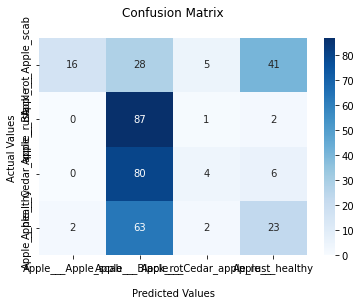

In [29]:
#https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
#Confusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred_ARGMAX)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [30]:
precision = precision_score(y_test, y_pred_ARGMAX, average = None)
accuracy = accuracy_score(y_test, y_pred_ARGMAX)
recall = recall_score(y_test, y_pred_ARGMAX, average = None)
f1 = f1_score(y_test, y_pred_ARGMAX, average = None)

In [31]:
#print('Precision: %.3f' % precision)
#print('Accuracy: %.3f' % accuracy)
#print('Recall: %.3f' % recall)
#print('F1-Score: %.3f' % f1)
format = {}

for n in range(len(class_names)):
    format[class_names[n]] = [precision[n]* 100, recall[n]* 100, f1[n]* 100]
    
df = pd.DataFrame(format, ['Precision', 'Recall', 'F1']).T
df

,Precision,Recall,F1
Apple___Apple_scab,88.888889,17.777778,29.629630
Apple___Black_rot,33.720930,96.666667,50.000000
Apple___Cedar_apple_rust,33.333333,4.444444,7.843137
Apple___healthy,31.944444,25.555556,28.395062


In [32]:
print('Accuracy: %.3f' % (accuracy * 100))

Accuracy: 36.111


In [33]:
saved_model.evaluate(x=test_batch, batch_size=32)

360/360 [==============================] - 8s 14ms/step - loss: 2.2127 - accuracy: 0.3611


[2.2127037048339844, 0.3611111044883728]